## Parts 2 & 3: Data Cleaning, EDA + Modelling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Read in csv file from previous part
real = pd.read_csv('reddit_chatgpt_df.csv')

#Data Cleaning 
real['answers'] = real['answers'].str.strip() #Removing white space from all ChatGPT answers
real = real.dropna() #Drop rows with NaN
real = real[real.top_comment != '[deleted]'] #Drop rows which include [deleted] in top comment
real = real[real.top_comment != '[removed]'] #Drop rows which include [removed] in top comment
real = real[real.top_comment != 'Welcome to r/TrueAskReddit. Remember that this subreddit is aimed at high quality discussion, so please elaborate on your answer as much as you can and avoid off-topic or jokey answers as per [subreddit rules](https://www.reddit.com/r/TrueAskReddit/about/sidebar).\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/TrueAskReddit) if you have any questions or concerns.*']
real['answers'] = real['answers'].str.replace('\n\n', ' ') #Delete line breaks from ChatGPT answers
real['top_comment'] = real['top_comment'].str.replace('\n', ' ') #Delete line breaks from Reddit comments
real = real[real.top_comment != f"A recent Reddit policy change threatens to kill many beloved third-party mobile apps, making a great many quality-of-life features not seen in the official mobile app **permanently inaccessible** to users.  On May 31, 2023, Reddit announced they were raising the price to make calls to their API from being free to a level that will kill every third party app on Reddit, from [Apollo](https://www.reddit.com/r/apolloapp/comments/13ws4w3/had_a_call_with_reddit_to_discuss_pricing_bad/) to [Reddit is Fun](https://www.reddit.com/r/redditisfun/comments/13wxepd/rif_dev_here_reddits_api_changes_will_likely_kill/) to [Narwhal](https://www.reddit.com/r/getnarwhal/comments/13wv038/reddit_have_quoted_the_apollo_devs_a_ridiculous/jmdqtyt/) to [BaconReader](https://www.reddit.com/r/baconreader/comments/13wveb2/reddit_api_changes_and_baconreader/).  Even if you're not a mobile user and don't use any of those apps, this is a step toward killing other ways of customizing Reddit, such as Reddit Enhancement Suite or the use of the old.reddit.com desktop interface .  This isn't only a problem on the user level: many subreddit moderators depend on tools only available outside the official app to keep their communities on-topic and spam-free.  &#x200B;  What can *you* do?  1. **Complain.** Message the mods of r/reddit.com, who are the admins of the site: message [/u/reddit](https://www.reddit.com/u/reddit/): submit a [support request](https://support.reddithelp.com/hc/en-us/requests/new): comment in relevant threads on [r/reddit](https://www.reddit.com/r/reddit/), such as [this one](https://www.reddit.com/r/reddit/comments/12qwagm/an_update_regarding_reddits_api/), leave a negative review on their official iOS or Android app- and sign your username in support to this post. 2. **Spread the word.** Rabble-rouse on related subreddits. Meme it up, make it spicy. Bitch about it to your cat. Suggest anyone you know who moderates a subreddit join us at our sister sub at [r/ModCoord](https://www.reddit.com/r/ModCoord/) \\- but please don't pester mods you *don't* know by simply spamming their modmail. 3. **Boycott** ***and*** **spread the word...to Reddit's competition!** Stay off Reddit as much as you can, instead, take to your favorite *non*\\-Reddit platform of choice and make some noise in support!   https://discord.gg/cscareerhub  https://programming.dev  4. **Don't be a jerk.** As upsetting this may be, threats, profanity and vandalism will be worse than useless in getting people on our side. Please make every effort to be as restrained, polite, reasonable and law-abiding as possible.   *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/cscareerquestions) if you have any questions or concerns.*"]
real['top_comment'] = real['top_comment'].str.replace('# ', ' ') #Deleting all # with a space afterwards as represents header

Text(0, 0.5, 'Word')

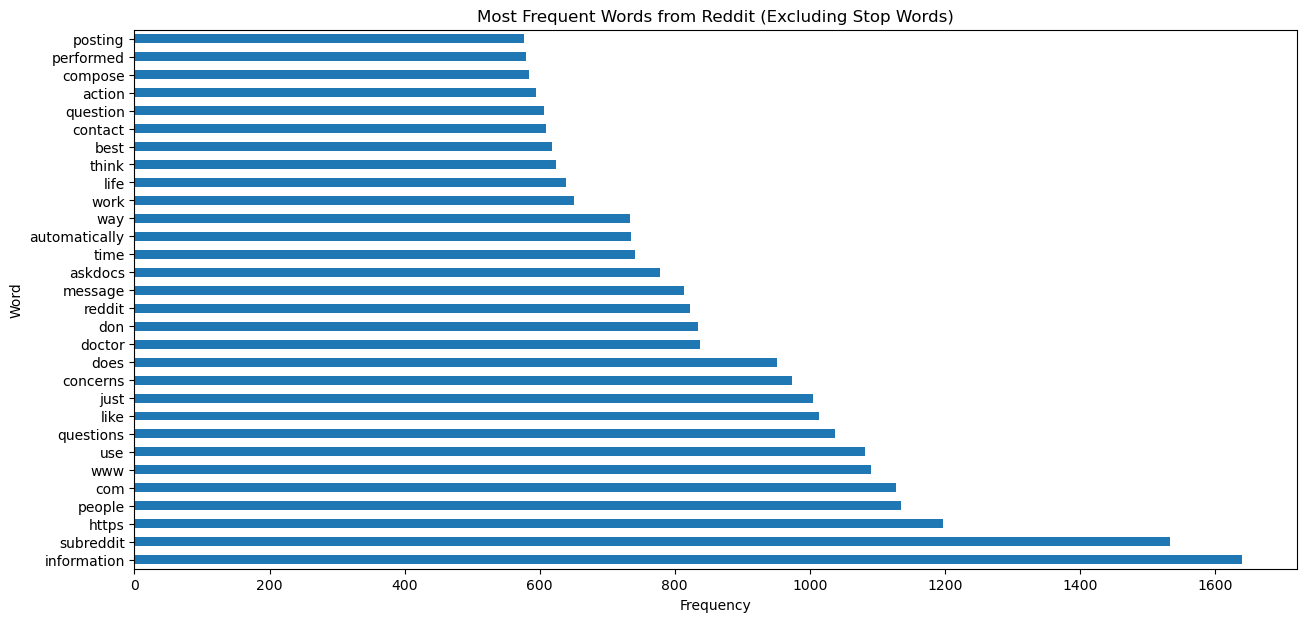

In [3]:
#Instantiate CVEC while excluding stop words
cvec = CountVectorizer(stop_words='english')
#Fit to column
cvec.fit(real['top_comment'])
#Transform column
top_comments = cvec.transform(real['top_comment'])
#Dataframe with transformed data
df_reddit_cvec = pd.DataFrame(top_comments.todense(), columns = cvec.get_feature_names_out())
df_reddit_cvec

#Set figure size
plt.figure(figsize=(15,7))
#Plotting 30 most used words
df_reddit_cvec.sum().sort_values(ascending=False).head(30).plot(kind='barh')
plt.title("Most Frequent Words from Reddit (Excluding Stop Words)")
plt.xlabel('Frequency')
plt.ylabel('Word')

In [4]:
# Define a list of keywords to check for in 'top_comment' column
keywords_to_exclude = ['www', 'https', 'com', 'subreddit', 'reddit', 'askdocs', 'askculinary', 'askengineers', 'cscareerquestions', 'TrueAskReddit']

# Iterate through each keyword and remove rows containing it in 'top_comment'
for keyword in keywords_to_exclude:
    real = real[~real['top_comment'].str.contains(keyword)]
# Reset index after removing rows
real.reset_index(drop=True, inplace=True)

In [5]:
#New dataframe with answers from human, and 0 to represent human response
df1 = pd.DataFrame()
df1['answer'] = real['top_comment']
df1['who_from'] = 0

#New dataframe with answers from AI, and 1 to represent AI response
df2 = pd.DataFrame()
df2['answer'] = real['answers']
df2['who_from'] = 1

#Put df1 and df2 together
df = pd.concat([df1, df2])
df = df.reset_index()
df = df.dropna()

In [6]:
#Split data into predictive variables and target variable
X = df['answer']
y = df['who_from']

#Baseline
y.value_counts(normalize = True)

#Train test split, test size 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_test baseline
y_test.value_counts(normalize = True)

who_from
0    0.528996
1    0.471004
Name: proportion, dtype: float64

0    0.531825
1    0.468175
Name: proportion, dtype: float64 0.9501238061549345 0.8896746817538896


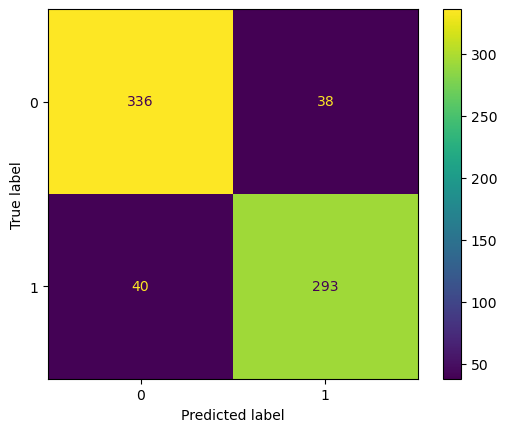

In [7]:
#Instantiate TFIDF vectorizer
tfidf = TfidfVectorizer()

#Fit and transforming training data
X_train_tfidf = tfidf.fit_transform(X_train)

#Transform testing data using same TFIDF Vectorizer
X_test_tfidf = tfidf.transform(X_test)

#Instantiate Log Regression model
lr = LogisticRegression()

#Fit Log Regression model to training data
lr.fit(X_train_tfidf, y_train)

#Predict target variable for testing data
y_pred = lr.predict(X_test_tfidf)

#Calculate confusion matrix using actual and predicted values
cm = confusion_matrix(y_test, y_pred)

#Create and display confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

#Calculate normalized value counts of predicted values (compare to baseline)
y_pred_norm = pd.Series(y_pred).value_counts(normalize = True)

#Calculate accuracy score on training data
train_score = lr.score(X_train_tfidf, y_train)

#Calculate accuracy score on testing data
test_score = lr.score(X_test_tfidf, y_test)

print(y_pred_norm, train_score, test_score)

0    0.611033
1    0.388967
Name: proportion, dtype: float64 {'cvec__max_df': 0.9, 'cvec__max_features': None, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None} 0.8747690672003504 0.9080297134771843 0.8783592644978784


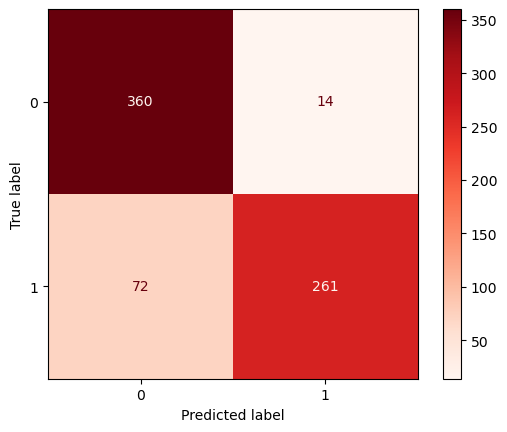

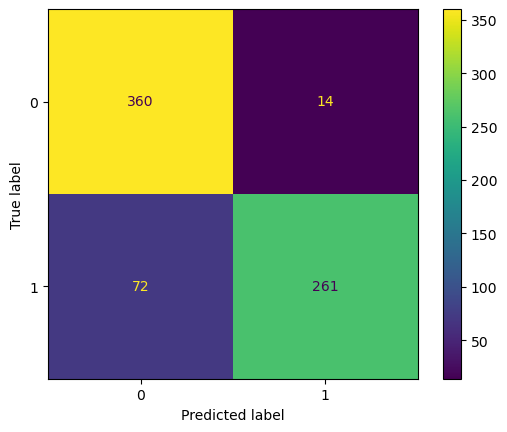

In [8]:
#Set up pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

#Setting up (English) stop words
nltk_stop = stopwords.words('english')

#Pipeline parameters
pipe_params = {
    'cvec__max_features' : [None, 1000], # Maximum number of features fit
    'cvec__min_df' : [1, 5, 10], # Minimum number of documents needed to include token
    'cvec__max_df' : [0.9, .95], # Maximum number of documents needed to include token
    'cvec__ngram_range' : [(1, 2), (1,1)], #Check (individual tokens) and also check (individual tokens and 2-grams)
    'cvec__stop_words' : ['english', None, nltk_stop] #Words to remove from text data
}

#Instantiate GridSearchCV.
gs = GridSearchCV(pipe, #Object we are optimizing
                  pipe_params, #Parameters values for which we are searching
                  cv = 5) #5-fold cross-validation

#Fit GridSearch to training data.
gs.fit(X_train, y_train)

#Get predictions
preds = gs.predict(X_test)

#View confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');
disp.plot()

#Calculate normalized value counts of predicted values (compare to baseline)
y_pred_norm = pd.Series(preds).value_counts(normalize = True)

#Calculate parameters which result in highest score
best_param = gs.best_params_

#Calculate highest mean score
best_score = gs.best_score_

#Calculate score on training data
train_score = gs.score(X_train, y_train)

#Calculate score on testing data
test_score = gs.score(X_test, y_test)

print(y_pred_norm, best_param, best_score, train_score, test_score)

0    0.553041
1    0.446959
Name: proportion, dtype: float64 {'cvec__max_df': 0.95, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None} 0.911211732699584 0.9918641669614432 0.9052333804809052


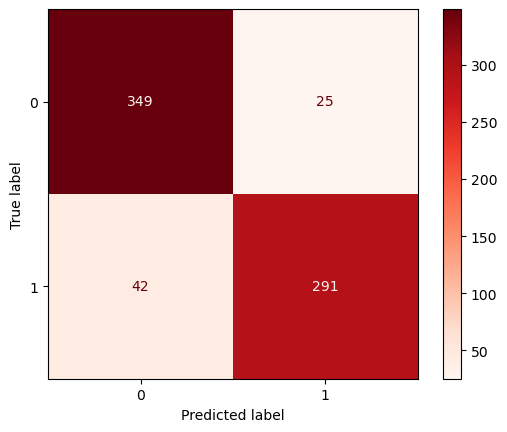

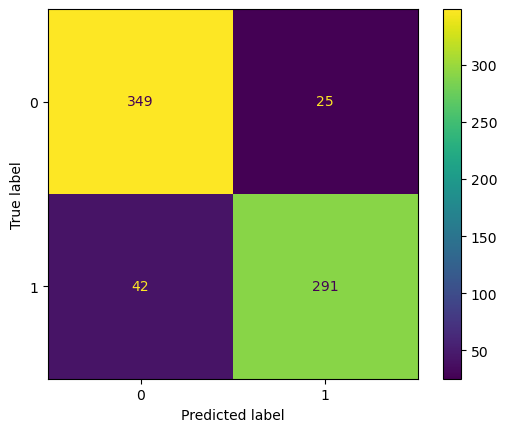

In [10]:
#Initalize Whitespace tokenizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
#Initalize WorkNet lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

#Define function to lemmatize text
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

#Apply lemmatization to predictive variables
X = df['answer'].apply(lemmatize_text)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Set up pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),  # Vectorization
    ('lr', LogisticRegression(max_iter=1000)) #Raised max_iter as was getting an error that total no. of iterations reached limit
])

#Pipeline parameters
pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [1, 10, 50],
    'cvec__max_df': [0.25, .5, 0.95],
    'cvec__ngram_range': [(1, 2), (1, 1)],
    'cvec__stop_words': ['english', None]
}

#Instantiate GridSearchCV
gs = GridSearchCV(pipe, #Object we are optimizing
                  pipe_params, #Parameters values for which we are searching
                  cv = 5) #5-fold cross-validation.

#Fit GridSearch to training data
gs.fit(X_train, y_train)

#Get predictions
preds = gs.predict(X_test)

#View confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');
disp.plot()

#Calculate normalized value counts of predicted values (compare to baseline)
y_pred_norm = pd.Series(preds).value_counts(normalize = True)

#Calculate parameters which result in highest score
best_param = gs.best_params_

#Calculate highest mean score
best_score = gs.best_score_

#Calculate score on training data
train_score = gs.score(X_train, y_train)

#Calculate score on testing data
test_score = gs.score(X_test, y_test)

print(y_pred_norm, best_param, best_score, train_score, test_score)